# FGCluster Tutorial 

In [61]:
import healpy as hp
import pylab as pl
import numpy as np
import time
from mpi4py import MPI
import argparse
import os
from os import path
import fgcluster as fgc
from fgcluster.spectral_clustering_mpi import (  
                                    build_adjacency_from_heat_kernel_gather ,
                                    build_adjacency_from_KS_distance_gather ,
                                    estimate_Laplacian_matrix,
                                    estimate_Ritz_eigenpairs,
                                    build_distance_matrix_from_eigenvectors,
                                    kolmogorov_smirnov_distance)

from fgbuster import   get_sky
from fgcluster import (
     utils as cu  )

from sklearn.cluster import AgglomerativeClustering

In [3]:
pl.style.use("seaborn-talk")

In [6]:
comm    = MPI.COMM_WORLD
workdir =os. getcwd()
rank =comm.Get_rank()
nprocs =comm.Get_size()
nside=4

### Generating features on the fly 

We simulate a map of features $\beta$ and its uncertainties $\sigma(\beta)$ (assumed 10% uncertainties)  from a _red_ power spectrum. 

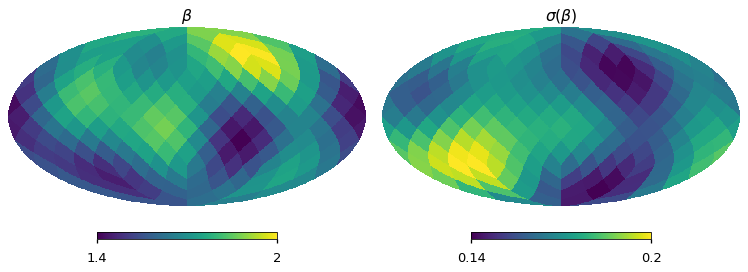

In [7]:
lmax= nside*3 
cl= np.zeros(lmax-1)
ell = np.arange(1,lmax ) 
cl[:nside] = 1./ell[:nside] **2 
param = hp. synfast (cl, nside=nside )
param= cu.minmaxrescale(param, a=1.4, b=2 )
sigmaparam = abs(param)*1e-2 
sigmaparam = hp. synfast (cl, nside=nside )
sigmaparam= cu.minmaxrescale(sigmaparam, a=param.min()/10, b=param.max()/10  )
hp.mollview(param,sub=121, title=r'$\beta$')
hp.mollview(sigmaparam, title=r'$\sigma(\beta) $', sub=122 )

### Make Adjacency maps 

1.  Estimate the Adjacency with Kolmogorov-Smirnov (KS) test to define the similarity from the statistical compatibility of measurements 

In [8]:
Q   = fgc.build_adjacency_from_KS_distance_nearest_neighbours(  nside=nside , comm=comm,
                                X= param, sigmaX=sigmaparam ,order_nn=0,  ntests =5, nresample=100   )

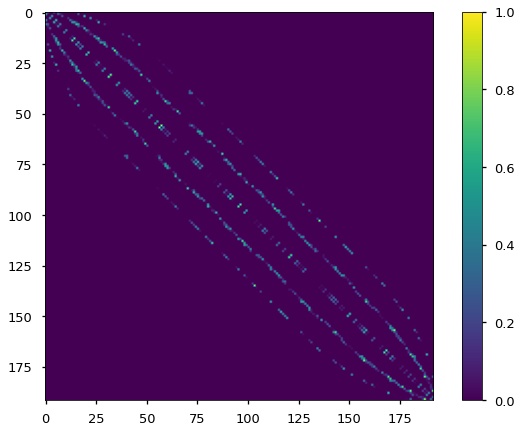

In [39]:
pl.imshow(Q); pl.colorbar() 

2. Estimate the Adjacency from the geometric affinity in the sphere with the Heat kernel 

In [9]:
A_hk = fgc.build_adjacency_from_heat_kernel_gather (nside, comm,  KS_weighted= False , Q=None  )

3. Deform the adjacency in 2. by means of the KS adjacency with weight $\alpha=0.2$ 

In [58]:
A_ks = fgc.build_adjacency_from_heat_kernel_gather (nside, comm,  KS_weighted= True , Q=Q , alpha=.2  )

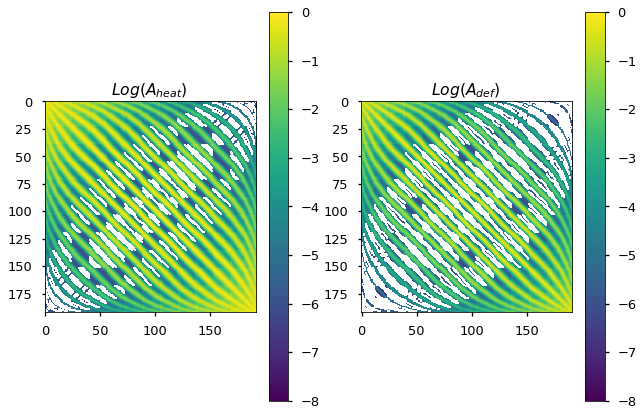

In [59]:
pl.subplot(121)
pl.imshow(np.log10(A_hk), vmin=-8,vmax=0 ) 
pl.title(r'$Log(A_{heat})$ ')
 
pl.colorbar() 
pl.subplot(122)
pl.title(r'$Log(A_{def})$ ')

pl.imshow(np.log10(A_ks), vmin=-8,vmax=0   )  
pl.colorbar() 

### Estimate Laplacian from the Adjacency matrix

In [80]:
L = estimate_Laplacian_matrix(A_ks ,kind='symmetric')

### Estimate the Ritz eigenpairs of the Laplacian  

In [81]:
lmax= nside -1
Nmax= np.int_(cu.from_ell_to_index(lmax )[1])
print(f"Estimating eigenvalues up to lmax= {nside  -1 }, i.e. the first {Nmax} eigenvectors of the Laplacian ")
l, W = estimate_Ritz_eigenpairs (L, n_eig = Nmax  )


Estimating eigenvalues up to lmax= 3, i.e. the first 16 eigenvectors of the Laplacian 


### Estimate the euclidean distance of the eigenvectors 

we do not consider the first eigenvector as it corresponds to a constant and project to a null vector space 

In [82]:
E = build_distance_matrix_from_eigenvectors(W[:,1:] ,comm=comm )

### Perform Agglomerative Clustering 

We set the distance threshold $\delta=0.4$ 


In [87]:
clusters  = AgglomerativeClustering(distance_threshold=0.3,affinity= 'precomputed',
                                   linkage='average', compute_full_tree=True, n_clusters=None   ).fit(E  )

patches = pl.int_( clusters.labels_)

### Plot the clusters 

The method finds 27 clusters . 

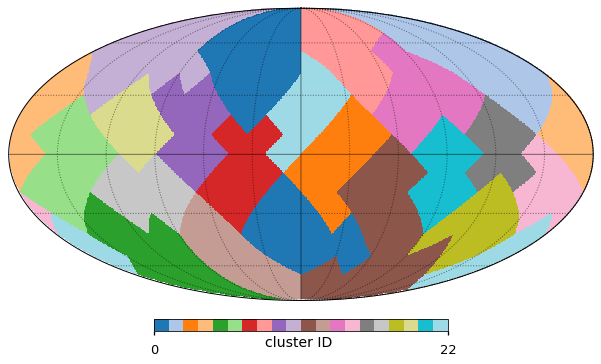

In [91]:
hp.mollview( patches,cmap=pl.cm.tab20, unit='cluster ID ',title=''  );
hp.graticule(alpha=.5)